# Data preprocess and Exploratory visualization

In [1]:
import numpy as np
import cv2
import os
import random
from tqdm import tqdm
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import mxnet as mx
import mxnet.image as image
from mxnet import nd

print("all module imported")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


all module imported


# Exploratory visualization

## 1 Load Image and Label
#### Transform label from (0~1360) and (0~800) to (0.0~1.0) and (0.0~1.0)

In [6]:
paths = glob.glob("dataset/scene-jpg/*.jpg")
labels = [[] for i in range(len(paths))]
width = 1360
height = 800
gts = open("dataset/gt.txt",'r').read().split('\n')[:-1]
for gt in gts:
    line = gt.split(";")
    idx = int(line[0].split(".")[0])
    minx = int(line[1])
    miny = int(line[2])
    maxx = int(line[3])
    maxy = int(line[4])
    label = int(line[5])
    labels[idx].append([minx, miny, maxx, maxy, label])
print(len(paths), len(gts), len(labels))
print(labels[2])

900 1213 900
[[892, 476, 1006, 592, 39]]


(512, 512, 3) uint8 1
[[0.600735294117647, 0.57375, 0.6161764705882353, 0.6, 2]]


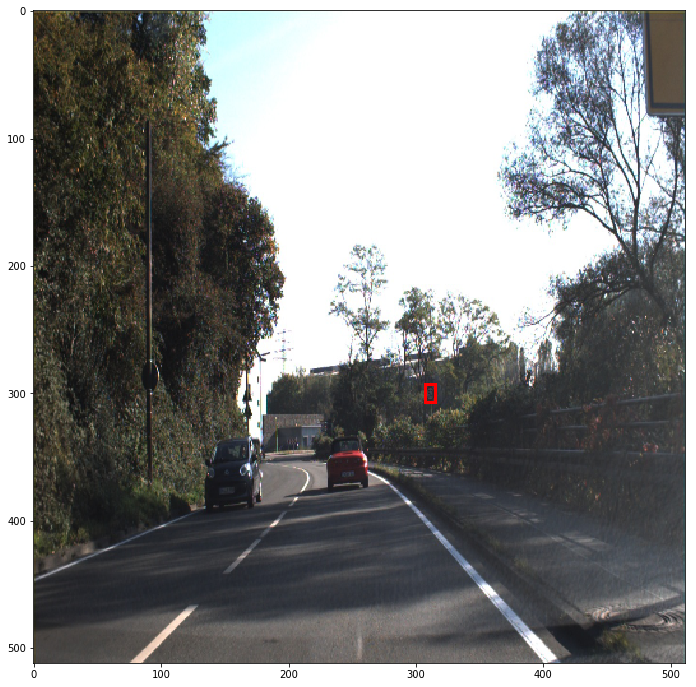

In [62]:
index = random.randint(0, len(paths))
img = plt.imread("dataset/scene-jpg/" + str(index).zfill(5) + ".jpg")
data_shape = 512
img = cv2.resize(img, (data_shape, data_shape))
label = labels[index]
print(img.shape, img.dtype, len(label))
print(label)

fig,ax = plt.subplots(1,  figsize=(12,12))
ax.imshow(img)
for box in label:
    minx = int(box[0] * data_shape)
    miny = int(box[1] * data_shape)
    maxx = int(box[2] * data_shape)
    maxy = int(box[3] * data_shape)
    rect = plt.Rectangle((minx, miny), maxx-minx, maxy-miny,fill=False, edgecolor='red', linewidth=3)
    ax.add_patch(rect)
plt.show()

# Image Generator
接下来，是我用三种方法读取训练数据的过程，分别是：
* 使用image.ImageDetIter读取多label数据集.rec和.idx （失败）
* 使用image.ImageIter通过.lst列表直接读取.jpg文件 （失败）
* 使用image.ImageIter读取单label数据集.rec和.idx，并反向使用编号label获得ground truth （成功）

## 1 使用image.ImageDetIter读取多label数据集.rec和.idx （失败）

## 1.1 制作多label的.lst文件

In [4]:
with open('dataset/dataset.lst', 'w+') as f:
    f.truncate()
    for i in range(len(labels)):
        lst = str(i) + '\t' + str(4) + '\t' + str(5) + '\t' + str(1360) + '\t' + str(800) + '\t'
        for label in labels[i]:
            lst += str(label[4]) + '\t' + str(round(label[0]/1360, 4)) + '\t' + str(round(label[1]/800,4)) + '\t'
            lst += str(round(label[2]/1360,4)) + '\t' +str(round(label[3]/800,4)) + '\t'
        lst += str(i).zfill(5) + '.jpg\n'
        f.write(lst)

## 1.2 制作多label的.rec和.idx文件

In [ ]:
！python3 im2rec.py --pack-label dataset.lst scene-jpg

## 1.3 使用image.ImageDetIter读取多label的.rec和.idx文件

In [93]:
train_iter = mx.image.ImageDetIter(  
   batch_size=16,
   data_shape=(3, 800, 1360),  
   path_imgrec='./dataset/dataset.rec',  
   path_imgidx='./dataset/dataset.idx',
   shuffle=True,  
   rand_crop=1,  
   min_object_covered=0.95,  
   max_attempts=200  
)

AttributeError: 'float' object has no attribute 'ravel'

## 2 使用image.ImageIter通过.lst列表直接读取.jpg文件 （失败）

## 2.1 制作单label的.lst文件

In [117]:
with open('dataset/dataset.lst', 'w+') as f:
    f.truncate()
    for i in range(len(labels)):
        label = labels[i][0]
        f.write(
            str(i) + '\t' + 
            str(4) + '\t' + str(5) + '\t' + 
            str(1360) + '\t' + str(800) + '\t' +
            str(label[4]) + '\t' + 
            str(round(label[0]/1360,4)) + '\t' + str(round(label[1]/800,4)) + '\t' + 
            str(round(label[2]/1360,4)) + '\t' +str(round(label[3]/800,4)) + '\t' + 
            str(i).zfill(5) + '.jpg\n'
        )

IndexError: index 4 is out of bounds for axis 0 with size 1

## 2.2 通过.lst列表直接读取.jpg文件

In [113]:
train_iter = mx.image.ImageIter(
        batch_size = 16,
        data_shape = (3, 800, 1360),
        label_width  = 1,
        path_imglist = "dataset/dataset.lst",
        path_root  = "dataset/scene-jpg",
        shuffle  = True)

batch = train_iter.next()
# print(batch)
print(batch.data[0].shape, batch.label[0].shape)
print(batch.label[0])

ValueError: operands could not be broadcast together with remapped shapes[original->remapped]: (9,) and requested shape (1,)

## 3 使用image.ImageIter读取单label数据集.rec和.idx，并使用编号获得label（成功）

## 3.1 制作编号作label的单label的.lst文件

In [121]:
with open('dataset/dataset.lst', 'w+') as f:
    f.truncate()
    for i in range(len(labels)):
        label = labels[i][0]
        f.write(
            str(i) + '\t' +  str(i) + '\t' +  
            str(i).zfill(5) + '.jpg\n'
        )

## 3.2 制作.rec和.idx文件

In [22]:
!python3 dataset/im2rec.py dataset/dataset.lst dataset/scene-jpg

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Creating .rec file from /notebooks/dataset/dataset.lst in /notebooks/dataset
multiprocessing not available, fall back to single threaded encoding
time: 0.04535651206970215  count: 0


## 3.3 使用image.ImageIter读取.rec和.idx文件

In [24]:
train_iter = mx.image.ImageIter(  
   batch_size=16, label_width = 1,
   data_shape=(3, 512, 512),  
   path_imgrec='./dataset/dataset.rec',  
   path_imgidx='./dataset/dataset.idx',  #help shuffle performance
   shuffle=True)

batch = train_iter.next()

# Visualize generated Image

In [143]:
# print(batch)
print(batch.data[0].shape, batch.label[0].shape)
batch_label = batch.label[0].asnumpy().astype(int)
print(batch_label)
print(labels[batch_label[0]])
# print(batch.data[0].max(),batch.data[0].min())
# print(batch.data[0].clip(0,255).max(),batch.data[0].clip(0,255).min())

(16, 3, 800, 1360) (16,)
[ 92 661 810 404  41 134 815 501 894 472 531 549 149 482 781 776]
[[718, 440, 739, 462, 13], [420, 419, 447, 446, 12], [423, 449, 444, 470, 35]]


92 [[718, 440, 739, 462, 13], [420, 419, 447, 446, 12], [423, 449, 444, 470, 35]]
661 [[1138, 401, 1169, 430, 2]]


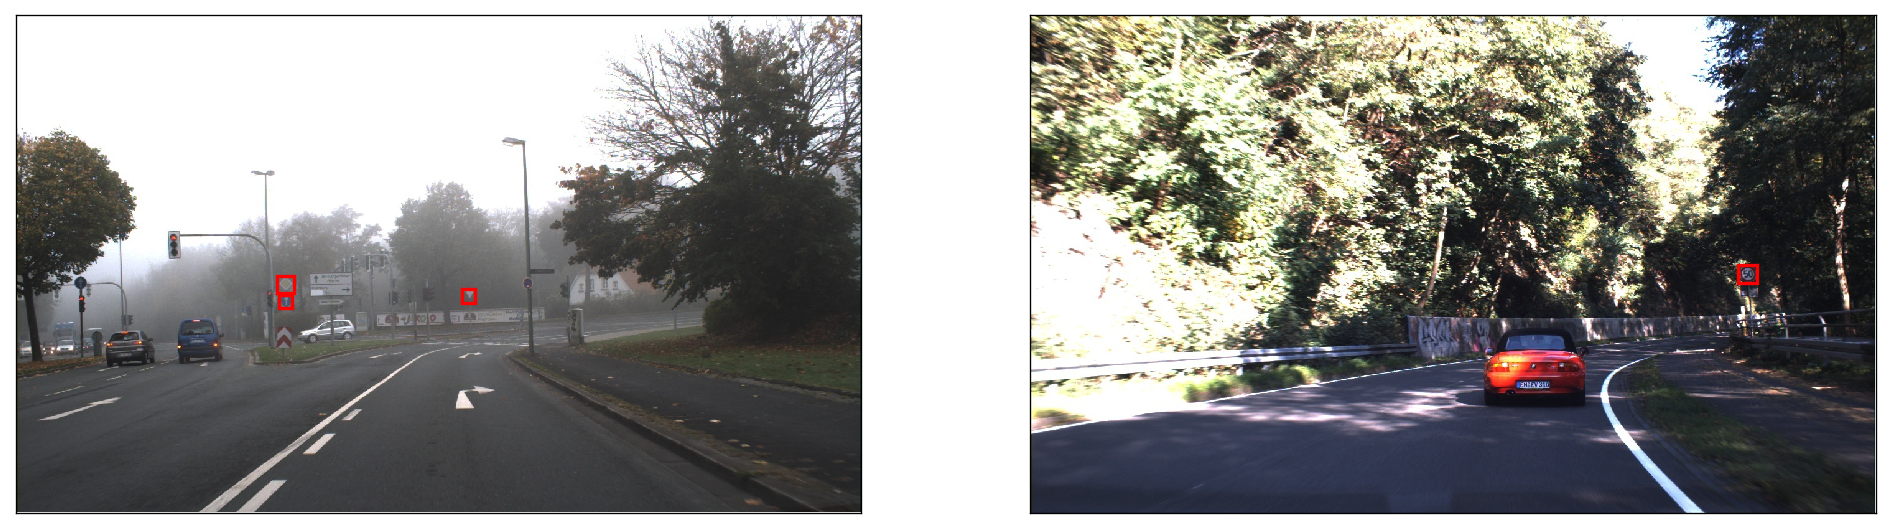

In [156]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 120

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
#     box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

_, figs = plt.subplots(1, 2, figsize=(20,20))
for i in range(2):
        img, _labels = batch.data[0][i], labels[batch_label[i]]
        print(batch_label[i], _labels)
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0))
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i]
        fig.imshow(img)
        for label in _labels:
            rect = box_to_rect(label[:-1],'red',2)
            fig.add_patch(rect)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

# Data Preprocess

In [17]:
# Resize image form (1360, 800) to (512,512)
for i in tqdm(range(len(paths))):
    img = mpimg.imread("dataset/scene/" + str(i).zfill(5) + ".ppm")
    img = cv2.resize(img, (512, 512))
    mpimg.imsave("dataset/scene-jpg/" + str(i).zfill(5) + ".jpg",img)

100%|██████████| 900/900 [01:11<00:00, 12.57it/s]


In [20]:
# Normalize label from (0,0) to (1360, 800) -> (0,0) to (1,1)
with open('dataset/gt1.txt', 'w+') as f:
    f.truncate()
    for gt in gts:
        line = gt.split(";")
        idx = int(line[0].split(".")[0])
        minx = round(int(line[1]) / 1360,4)
        miny = round(int(line[2]) / 800,4)
        maxx = round(int(line[3]) / 1360,4)
        maxy = round(int(line[4]) / 800,4)
        label = int(line[5])
        f.write(str(idx).zfill(5)+".jpg;"+str(minx)+";"+str(miny)+";"+str(maxx)+";"+str(maxy)+";" + str(label)+"\n")